# Ultimate Technologies — Data Science Challenge (EDA → Experiment Design → Predictive Modeling)

This notebook is organized to match the three required parts:

1. **Part 1 — Exploratory Data Analysis (logins.json)**
2. **Part 2 — Experiment and Metrics Design (Gotham ↔ Metropolis toll reimbursement)**
3. **Part 3 — Predictive Modeling (ultimate_data_challenge.json)**

**Data files expected**
- `logins.json` is available in this runtime at: `/mnt/data/logins.json`
- `ultimate_data_challenge.json` must be present at one of:
  - `/mnt/data/ultimate_data_challenge.json`
  - `./ultimate_data_challenge.json` (current working directory)

> Note: If the modeling dataset is not present, the notebook will print a clear instruction and skip model fitting steps.


In [18]:
# Core libraries
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_STATE = 42


## Part 1 — Exploratory Data Analysis (logins.json)

**Goal:** Aggregate login counts into **15-minute bins**, visualize the time series, and describe demand patterns (daily/weekly cycles) while noting any data quality issues.

### Approach
- Parse timestamps into a timezone-naïve `datetime64[ns]` series.
- Create a 15-minute resampled count series.
- Characterize cycles:
  - **Time series** (raw binned counts)
  - **Average by time-of-day** (circadian pattern)
  - **Average by day-of-week** (weekday vs weekend)
  - **Day-of-week × time-of-day heatmap** (combined effect)


In [19]:
# Load logins.json
logins_path = Path("logins.json")
if not logins_path.exists():
    raise FileNotFoundError(f"Expected logins.json at {logins_path}")

with logins_path.open("r", encoding="utf-8") as f:
    logins_raw = json.load(f)

# The file is a list of dicts like {"login_time": "1970-01-01 20:13:18"}
logins_df = pd.DataFrame(logins_raw)

# Basic schema checks
display(logins_df.head())
print("Rows:", len(logins_df))
print("Columns:", list(logins_df.columns))

# Parse timestamps
logins_df["login_time"] = pd.to_datetime(logins_df["login_time"], errors="coerce")

# Data quality checks
n_null = logins_df["login_time"].isna().sum()
n_dup = logins_df.duplicated().sum()
print(f"Null timestamps: {n_null}")
print(f"Duplicate rows:  {n_dup}")

# Remove null timestamps; keep duplicates as they may represent distinct events at the same second
logins_df = logins_df.dropna(subset=["login_time"]).copy()

# Create 15-minute bins
logins_ts = (
    logins_df
    .set_index("login_time")
    .sort_index()
    .resample("15min")
    .size()
    .rename("logins")
)

display(logins_ts.head(20))
print("Time span:", logins_ts.index.min(), "→", logins_ts.index.max())


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Rows: 93142
Columns: ['login_time']
Null timestamps: 0
Duplicate rows:  877


login_time
1970-01-01 20:00:00     2
1970-01-01 20:15:00     6
1970-01-01 20:30:00     9
1970-01-01 20:45:00     7
1970-01-01 21:00:00     1
1970-01-01 21:15:00     4
1970-01-01 21:30:00     0
1970-01-01 21:45:00     4
1970-01-01 22:00:00     9
1970-01-01 22:15:00     8
1970-01-01 22:30:00     1
1970-01-01 22:45:00     3
1970-01-01 23:00:00    16
1970-01-01 23:15:00    13
1970-01-01 23:30:00    14
1970-01-01 23:45:00    15
1970-01-02 00:00:00    10
1970-01-02 00:15:00    18
1970-01-02 00:30:00    12
1970-01-02 00:45:00    13
Freq: 15min, Name: logins, dtype: int64

Time span: 1970-01-01 20:00:00 → 1970-04-13 18:45:00


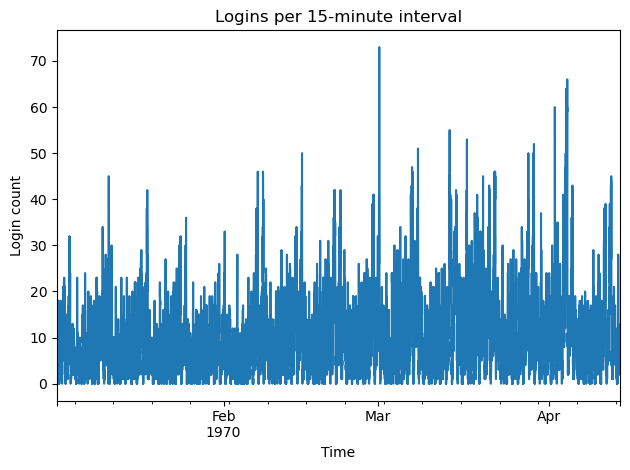

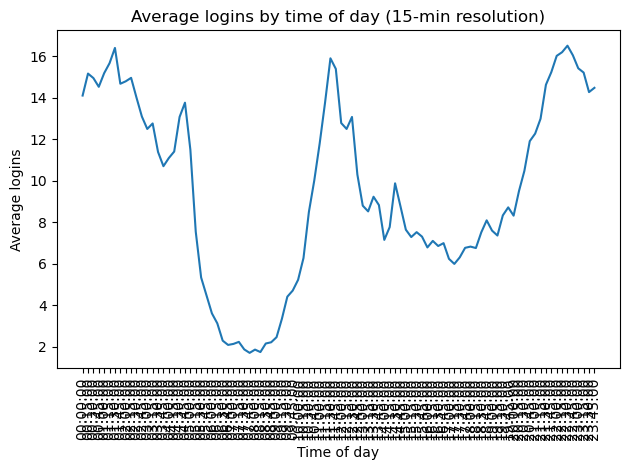

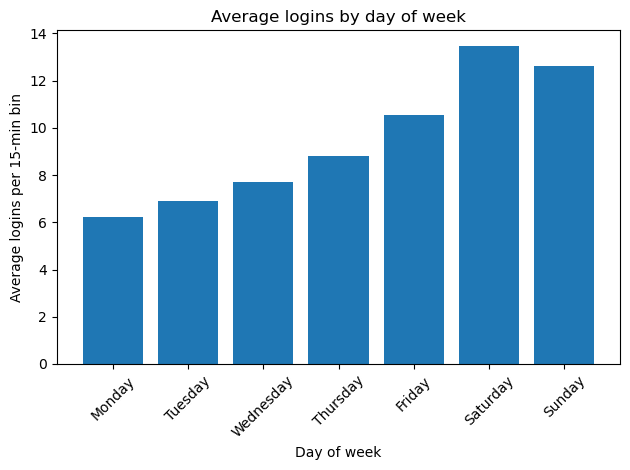

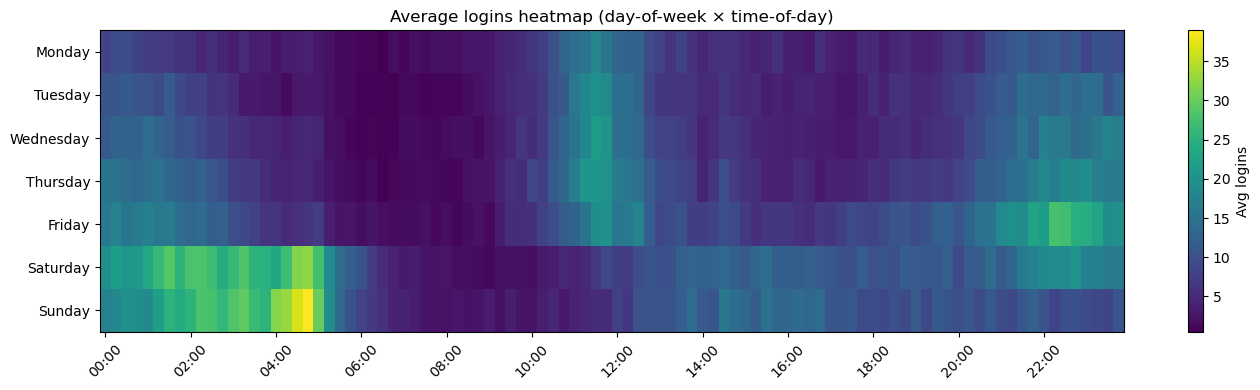

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: logins, dtype: float64


In [20]:
# 1) Overall 15-minute time series
plt.figure()
logins_ts.plot()
plt.title("Logins per 15-minute interval")
plt.xlabel("Time")
plt.ylabel("Login count")
plt.tight_layout()
plt.show()

# 2) Average by time of day (circadian pattern)
tod = logins_ts.copy()
tod.index = tod.index.time
tod_avg = tod.groupby(tod.index).mean()

plt.figure()
plt.plot(tod_avg.index.astype(str), tod_avg.values)
plt.title("Average logins by time of day (15-min resolution)")
plt.xlabel("Time of day")
plt.ylabel("Average logins")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3) Average by day of week
dow = logins_ts.copy()
dow_df = dow.to_frame()
dow_df["dow"] = logins_ts.index.day_name()

dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_avg = dow_df.groupby("dow")["logins"].mean().reindex(dow_order)

plt.figure()
plt.bar(dow_avg.index, dow_avg.values)
plt.title("Average logins by day of week")
plt.xlabel("Day of week")
plt.ylabel("Average logins per 15-min bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4) Heatmap: day-of-week vs time-of-day
heat = logins_ts.to_frame()
heat["dow"] = heat.index.day_name()
heat["time"] = heat.index.time

heat_pivot = heat.pivot_table(index="dow", columns="time", values="logins", aggfunc="mean").reindex(dow_order)

plt.figure(figsize=(14, 4))
plt.imshow(heat_pivot.values, aspect="auto")
plt.title("Average logins heatmap (day-of-week × time-of-day)")
plt.yticks(range(len(heat_pivot.index)), heat_pivot.index)
# X tick labels: show every 8th 15-min step (2 hours)
col_positions = np.arange(0, heat_pivot.shape[1], 8)
plt.xticks(col_positions, [str(list(heat_pivot.columns)[i])[:5] for i in col_positions], rotation=45)
plt.colorbar(label="Avg logins")
plt.tight_layout()
plt.show()

# Summary statistics
print(logins_ts.describe())


### Part 1 — Findings (fill in from the plots above)

Use these prompts to ensure you explicitly answer the rubric expectations:

- **Daily cycle:** Identify peak periods (e.g., commute, lunch, evening, late night) and troughs (e.g., early morning).
- **Weekly cycle:** Identify which days have higher/lower average demand.
- **Variance / volatility:** Comment on whether demand is spiky or smooth, and whether variance differs by day.
- **Data quality issues:** 
  - Null timestamps (if any) were removed.
  - Exact duplicate rows are reported; duplicate *timestamps* are not inherently an error (multiple users can log in at the same second).
  - If the dataset uses the date `1970-01-01`, treat it as a simulated baseline date; the **intra-day** and **weekday/weekend** patterns remain interpretable.


## Part 2 — Experiment and Metrics Design (Toll reimbursement)

### Background
Gotham and Metropolis exhibit complementary weekday demand profiles:
- Gotham: more active at **night**
- Metropolis: more active during the **day**
A **two-way toll bridge** disincentivizes cross-city driving, leading to driver “exclusivity” by city.

The proposal is to **reimburse toll costs** to encourage drivers to operate in both cities.

---

### Q1. Key measure of success (and why)

**Primary success metric (recommended):**
- **Cross-city driver supply share during deficit periods**  
  > The fraction of total online driver-minutes (or driver-hours) in the *deficit city* that is contributed by drivers who also served the other city within the same week.

**Why this metric:**
- It measures *the direct behavioral objective* (drivers operating in both cities).
- It is supply-side and thus less confounded by demand shocks than purely demand-side metrics.
- It can be computed reliably using existing GPS + trip logs and driver online time.

**Operational definition (example):**
- Define “cross-city driver” as any driver who completes ≥1 trip in **both** cities during the observation window (e.g., week).
- Compute:
  - `cross_city_supply_minutes_in_city / total_supply_minutes_in_city`  
  separately for Gotham deficit windows and Metropolis deficit windows.

**Secondary customer-impact metric (complements the primary):**
- **P90 rider ETA / pickup wait time** in the deficit city during deficit periods.
  - This captures whether changes in supply translate into better customer experience.

**Guardrails (do-not-harm metrics):**
- Cancellation rate, unfulfilled request rate
- Driver earnings per hour, driver app engagement / churn
- Fraud indicators (e.g., bridge crossings without service)
- Net contribution margin (reimbursement cost vs incremental trips)

---

### Q2. Practical experiment design + statistical test(s) + interpretation

**Design: randomized controlled trial (driver-level randomization)**
- **Population:** Active drivers in Gotham and Metropolis.
- **Eligibility:** Drivers who have driven at least _k_ trips/week recently (to reduce noise).
- **Randomization unit:** **Driver** (not trip), to avoid within-driver contamination.
- **Stratification:** By home city and historical cross-city behavior (e.g., prior bridge-crossing rate) to balance baseline differences.
- **Treatment:** Automatic reimbursement of toll costs when the driver crosses the bridge.
- **Control:** No reimbursement; status quo.

**Duration:** 4–8 weeks minimum (longer if power calculations indicate), including at least one full demand cycle of weekdays/weekends.

**Statistical tests (typical choices):**
- For the primary metric (a proportion/ratio):
  - **Two-sample t-test** on driver-level weekly cross-city supply share (often robust with many drivers), *or*
  - **Mann–Whitney U** if distribution is highly skewed.
- For binary outcomes at driver level (e.g., “became cross-city driver this week”):
  - **Two-proportion z-test** or **logistic regression** with covariates (home city, baseline activity).
- For wait time / ETA (continuous, skewed):
  - Compare **P90** via bootstrap confidence intervals, or compare log-transformed ETAs.

**Interpretation and recommendation framework:**
- Roll out if:
  - Primary metric increases meaningfully (business-relevant effect size) **and**
  - Guardrails are neutral/positive **and**
  - Net economics are acceptable (incremental contribution exceeds reimbursement cost).
- If results are mixed:
  - Iterate (e.g., reimburse only during deficit windows, cap reimbursements, target drivers most likely to switch, improve messaging).

**Key caveats:**
- **Interference / network effects:** Driver behavior affects rider metrics (and vice versa). Driver-level randomization reduces, but does not eliminate spillovers.
- **Seasonality and events:** Holidays or unusual demand weeks can confound. Use multiple weeks and consider diff-in-diff with pre-period.
- **Compliance and fraud:** Ensure reimbursement triggers are tied to verified trips and bridge crossings.


## Part 3 — Predictive Modeling (ultimate_data_challenge.json)

**Goal:** Predict whether a user will be “active” in their 6th month.

### Label definition (retention)
Per prompt, a user is **retained** if they were active (took a trip) in the **preceding 30 days** relative to the data pull date.

Because the exact pull date is not explicitly provided, this notebook uses a practical, auditable convention:
- `data_pull_date = max(last_trip_date) + 1 day`
- `retained = last_trip_date >= (data_pull_date - 30 days)`

This aligns with “preceding 30 days” while relying only on observed data.

### Modeling approach (high-level)
1. **Cleaning & EDA**
   - Parse date fields
   - Convert booleans and categoricals
   - Impute missing values
2. **Baseline model:** Logistic Regression (interpretable, strong baseline)
3. **Nonlinear model:** Random Forest (captures interactions/nonlinearities)
4. **Validation:** Holdout test set + cross-validation
5. **Performance metrics:** ROC-AUC, precision/recall, confusion matrix; pick an operating point suitable for retention interventions.


In [21]:
# Locate dataset
candidate_paths = [
    Path("/mnt/data/ultimate_data_challenge.json"),
    Path("./ultimate_data_challenge.json"),
]

data_path = next((p for p in candidate_paths if p.exists()), None)

if data_path is None:
    print("ultimate_data_challenge.json not found.")
    print("Place the file at /mnt/data/ultimate_data_challenge.json or in the current working directory, then re-run Part 3 cells.")
else:
    print("Found dataset at:", data_path.resolve())


Found dataset at: C:\Users\OR0293533\ultimate_data_challenge.json


In [22]:
if data_path is not None:
    # Load JSON
    with data_path.open("r", encoding="utf-8") as f:
        raw = json.load(f)

    df = pd.DataFrame(raw)
    display(df.head())
    print("Shape:", df.shape)
    print(df.dtypes)

    # Parse dates
    df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")
    df["last_trip_date"] = pd.to_datetime(df["last_trip_date"], errors="coerce")

    # Create retention label
    # Conservative convention: pull date is the day after the last observed trip date
    data_pull_date = df["last_trip_date"].max() + pd.Timedelta(days=1)
    retained_cutoff = data_pull_date - pd.Timedelta(days=30)

    df["retained"] = (df["last_trip_date"] >= retained_cutoff).astype(int)

    frac_retained = df["retained"].mean()
    print(f"Data pull date (inferred): {data_pull_date.date()}")
    print(f"Retained cutoff (>=):      {retained_cutoff.date()}")
    print(f"Fraction retained:         {frac_retained:.4f}")

    # Quick missingness summary
    missing = df.isna().mean().sort_values(ascending=False)
    display(missing.to_frame("missing_fraction").head(15))

    # Basic target balance
    print(df["retained"].value_counts(normalize=True).rename("proportion"))


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


Shape: (50000, 12)
city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object
Data pull date (inferred): 2014-07-02
Retained cutoff (>=):      2014-06-02
Fraction retained:         0.3662


,missing_fraction
avg_rating_of_driver,0.16244
phone,0.00792
avg_rating_by_driver,0.00402
city,0.00000
trips_in_first_30_days,0.00000
avg_surge,0.00000
signup_date,0.00000
surge_pct,0.00000
last_trip_date,0.00000
ultimate_black_user,0.00000


retained
0    0.6338
1    0.3662
Name: proportion, dtype: float64


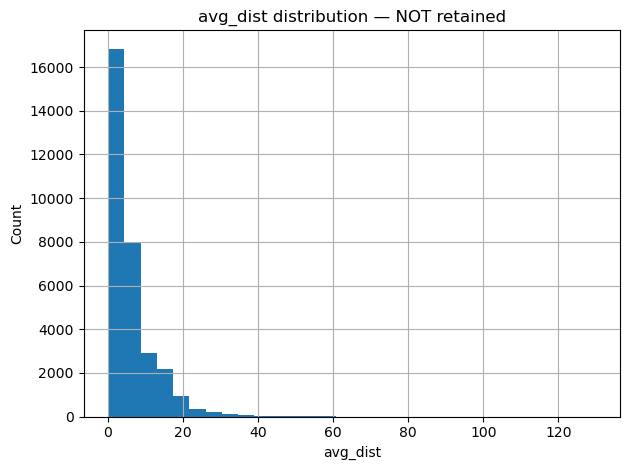

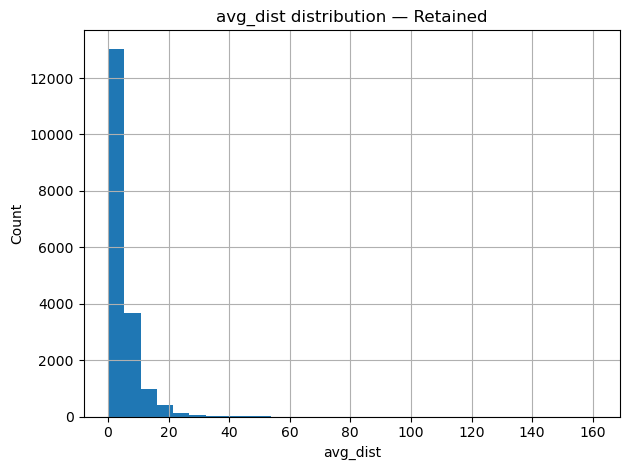

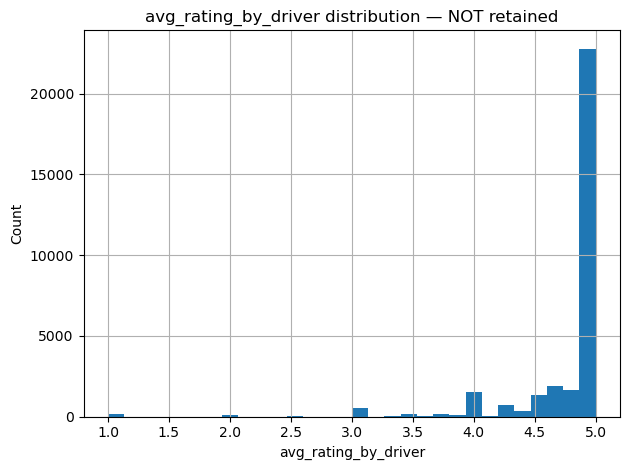

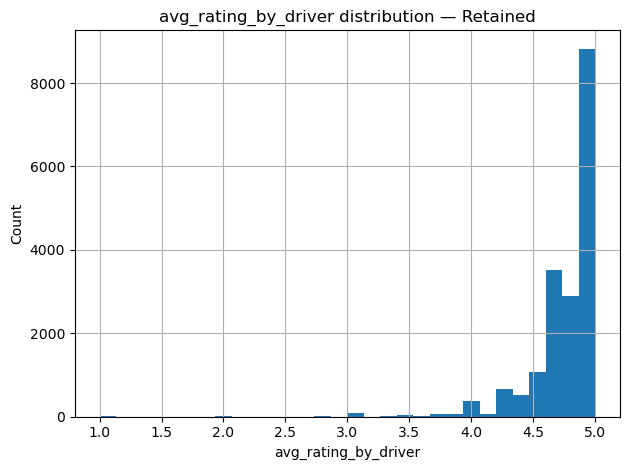

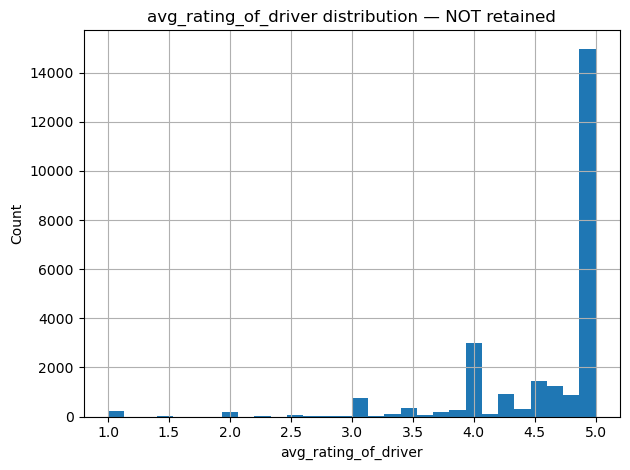

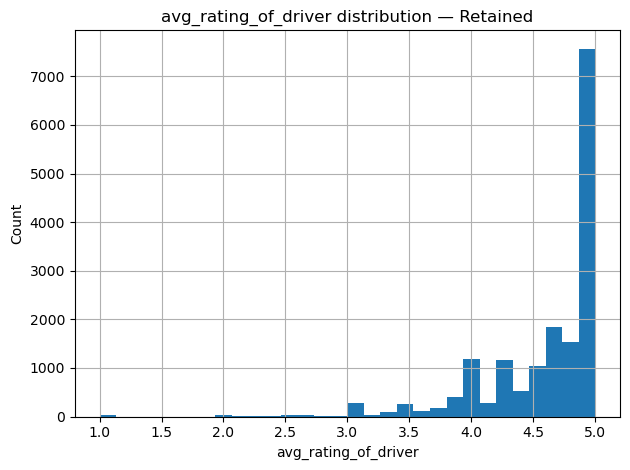

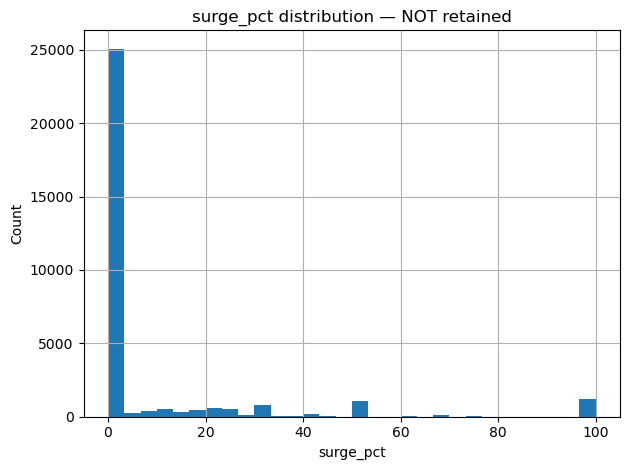

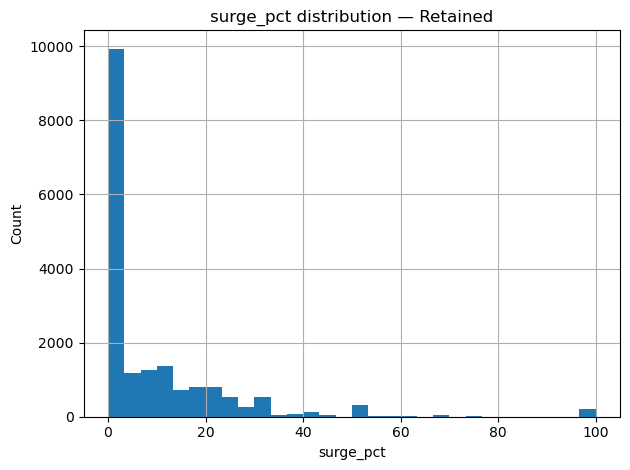

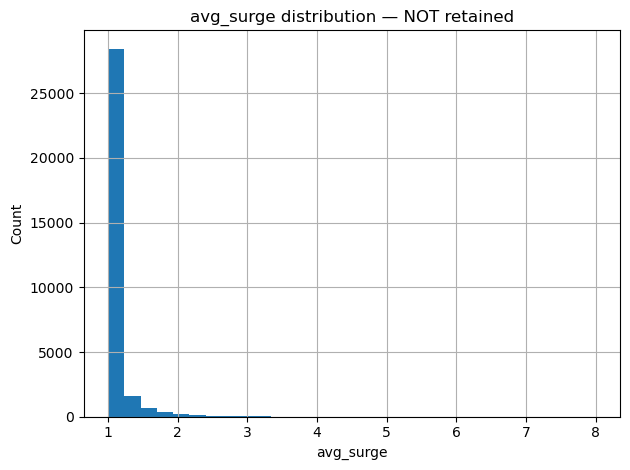

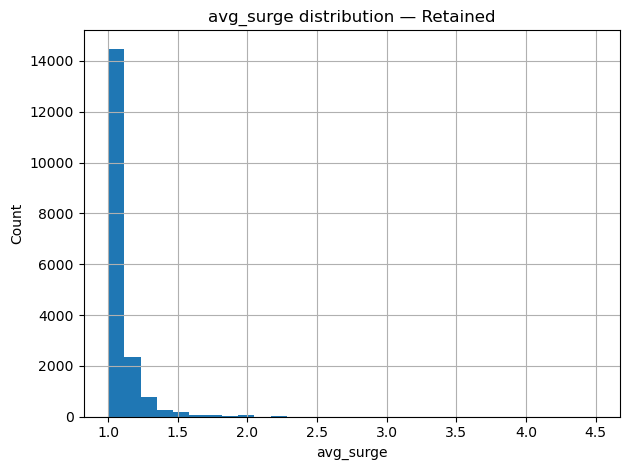

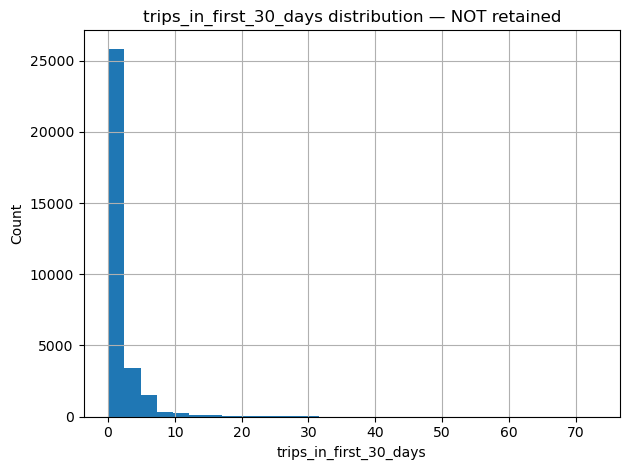

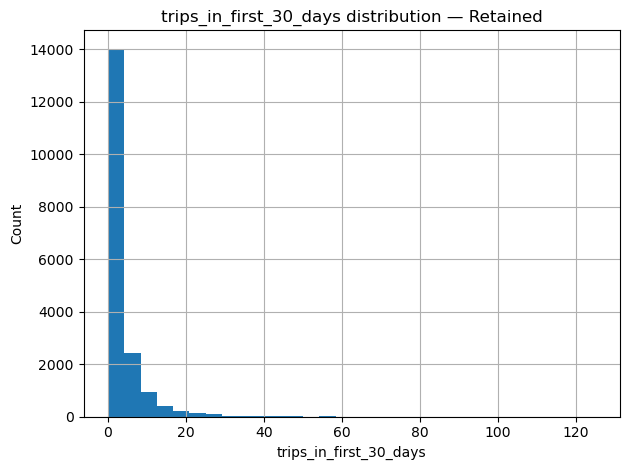

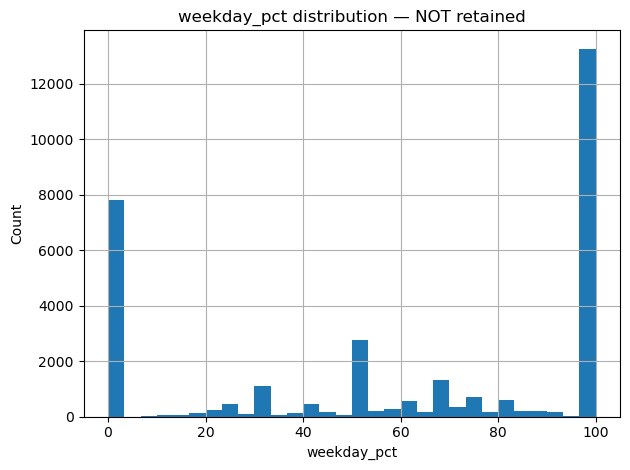

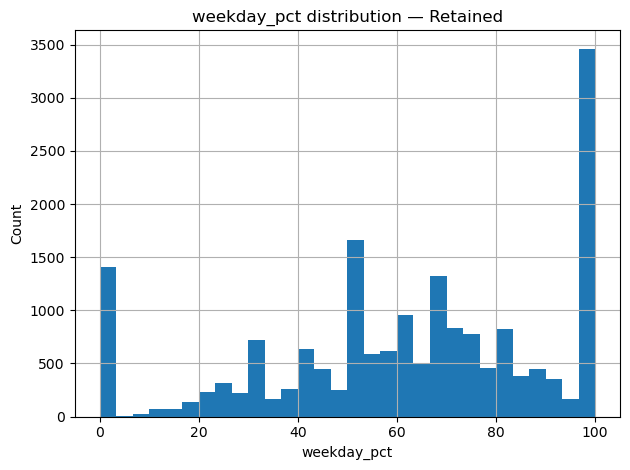

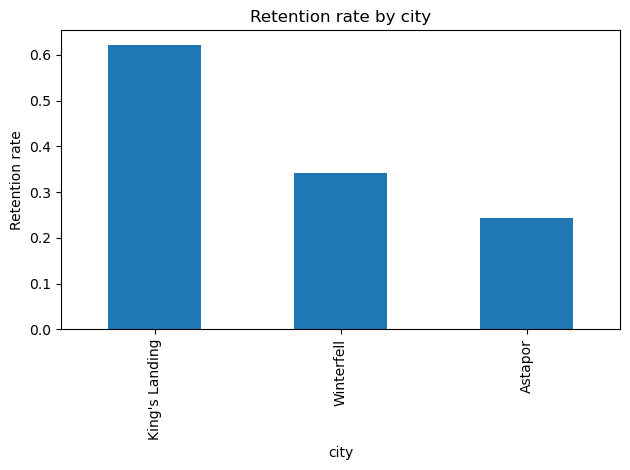

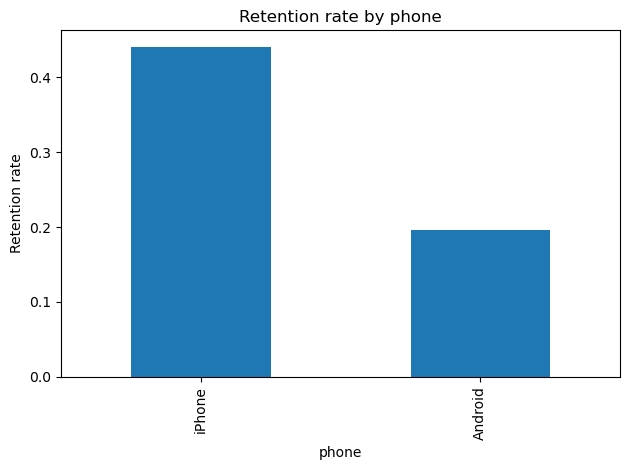

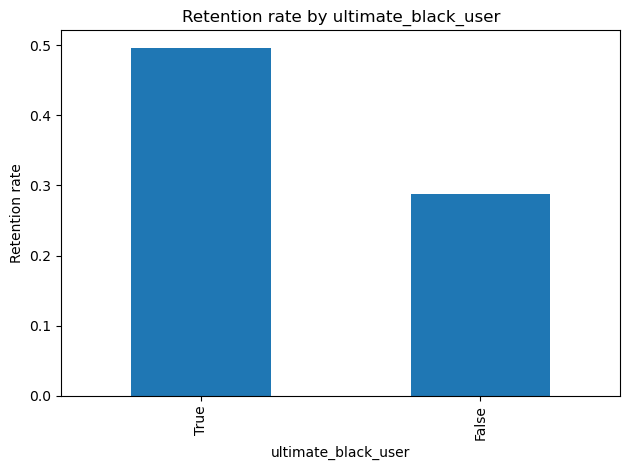

In [23]:
if data_path is not None:
    # Simple EDA plots for key numeric predictors vs retention
    numeric_cols = [
        "avg_dist",
        "avg_rating_by_driver",
        "avg_rating_of_driver",
        "surge_pct",
        "avg_surge",
        "trips_in_first_30_days",
        "weekday_pct",
    ]

    # Ensure columns exist (robustness)
    numeric_cols = [c for c in numeric_cols if c in df.columns]

    for c in numeric_cols:
        plt.figure()
        df.loc[df["retained"] == 0, c].dropna().hist(bins=30)
        plt.title(f"{c} distribution — NOT retained")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

        plt.figure()
        df.loc[df["retained"] == 1, c].dropna().hist(bins=30)
        plt.title(f"{c} distribution — Retained")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # Categorical breakdown
    cat_cols = ["city", "phone", "ultimate_black_user"]
    cat_cols = [c for c in cat_cols if c in df.columns]

    for c in cat_cols:
        plt.figure()
        (df.groupby(c)["retained"].mean().sort_values(ascending=False)).plot(kind="bar")
        plt.title(f"Retention rate by {c}")
        plt.ylabel("Retention rate")
        plt.tight_layout()
        plt.show()


### Q2. Build a predictive model (choices, alternatives, concerns, validity)

**Chosen approach**
- **Logistic Regression (baseline):**
  - Interpretable coefficients (directionality of drivers of retention)
  - Strong default for tabular binary classification
- **Random Forest (alternative):**
  - Captures nonlinearities and interactions without feature engineering
  - Provides feature importance as a directional signal (with caveats)

**Alternatives considered**
- Gradient boosted trees (XGBoost/LightGBM/CatBoost): typically top-performing on tabular data.
- Calibrated models (Platt scaling / isotonic) if probability calibration is needed for decisioning.
- Survival analysis / time-to-churn framing if we had longitudinal activity rather than a single cohort snapshot.

**Concerns**
- Retention label depends on an inferred pull date; if the true pull date differs, the label could shift.
- Potential leakage: avoid using any feature that directly encodes “future activity” beyond the first 30 days.
- Class imbalance: typically moderate; we assess and (if needed) use class weights.

**Validity**
- Use a holdout test set and cross-validation, report ROC-AUC + classification metrics.
- Prefer ROC-AUC for overall separability; select a threshold based on business constraints (e.g., how many users can be targeted with retention offers).


LogisticRegression
ROC-AUC: 0.7659
Confusion matrix:
 [[4646 1692]
 [1245 2417]]
              precision    recall  f1-score   support

           0      0.789     0.733     0.760      6338
           1      0.588     0.660     0.622      3662

    accuracy                          0.706     10000
   macro avg      0.688     0.697     0.691     10000
weighted avg      0.715     0.706     0.709     10000



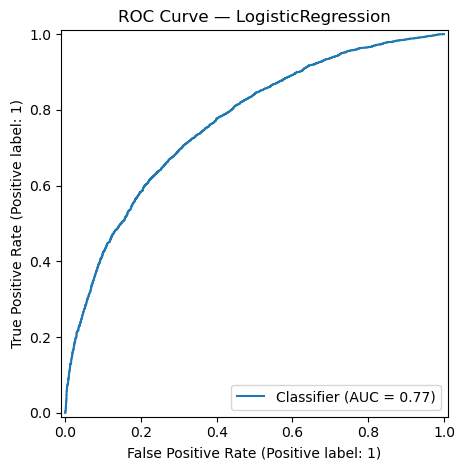

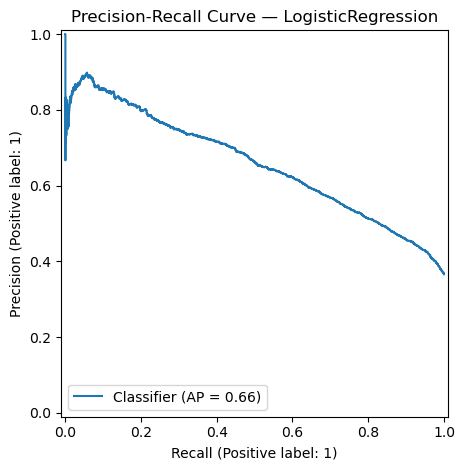

RandomForest
ROC-AUC: 0.8263
Confusion matrix:
 [[5202 1136]
 [1263 2399]]
              precision    recall  f1-score   support

           0      0.805     0.821     0.813      6338
           1      0.679     0.655     0.667      3662

    accuracy                          0.760     10000
   macro avg      0.742     0.738     0.740     10000
weighted avg      0.758     0.760     0.759     10000



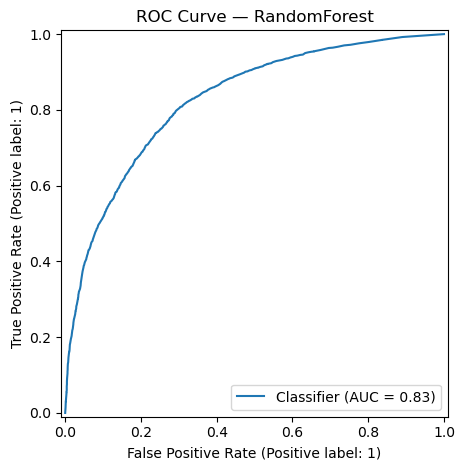

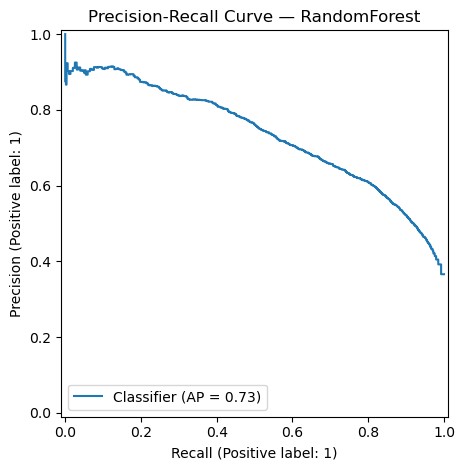

,roc_auc
RandomForest,0.826316
LogisticRegression,0.765851


In [24]:
if data_path is not None:
    # Feature set
    target = "retained"

    # Drop columns that would leak or are identifiers/time references.
    # Keep signup_date only if you convert it to a safe cohort feature; for this cohort it's constant-ish.
    drop_cols = ["last_trip_date", "signup_date"]
    feature_df = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()

    X = feature_df.drop(columns=[target])
    y = feature_df[target].astype(int)

    # Identify column types
    categorical_features = [c for c in X.columns if X[c].dtype == "object" or c in ["ultimate_black_user"]]
    # Booleans may be stored as bool; treat them as categorical for one-hot encoding
    for c in X.columns:
        if X[c].dtype == "bool" and c not in categorical_features:
            categorical_features.append(c)

    numeric_features = [c for c in X.columns if c not in categorical_features]

    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="drop"
    )

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    # Models
    logit = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
    rf = RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    )

    pipelines = {
        "LogisticRegression": Pipeline(steps=[("prep", preprocessor), ("model", logit)]),
        "RandomForest": Pipeline(steps=[("prep", preprocessor), ("model", rf)]),
    }

    results = {}
    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)

        # Probabilities for ROC-AUC
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        auc = roc_auc_score(y_test, y_proba)
        results[name] = {"roc_auc": auc}

        print("=" * 80)
        print(name)
        print("ROC-AUC:", round(auc, 4))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred, digits=3))

        # ROC and PR curves
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve — {name}")
        plt.tight_layout()
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Precision-Recall Curve — {name}")
        plt.tight_layout()
        plt.show()

    display(pd.DataFrame(results).T.sort_values("roc_auc", ascending=False))


In [ ]:
if data_path is not None:
    # Cross-validation on the best-performing pipeline (by ROC-AUC on holdout above)
    # If you prefer, manually select the pipeline you want to validate.
    best_name = max(results, key=lambda k: results[k]["roc_auc"])
    best_pipe = pipelines[best_name]
    print("Selected for CV:", best_name)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scoring = {"roc_auc": "roc_auc", "precision": "precision", "recall": "recall", "f1": "f1"}

    cv_out = cross_validate(best_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_summary = {k: (np.mean(v), np.std(v)) for k, v in cv_out.items() if k.startswith("test_")}
    cv_df = pd.DataFrame(cv_summary, index=["mean", "std"]).T
    display(cv_df)

    print("Interpretation:")
    print("- If CV ROC-AUC is stable (low std), generalization is likely acceptable for this cohort.")
    print("- Use precision/recall trade-offs to set an intervention threshold based on budget/capacity.")


Selected for CV: RandomForest


### Q3. How to leverage insights to improve long-term retention

Once you validate performance, use the model in two complementary ways:

1. **Targeted interventions (decisioning)**
   - Score new users at day 30 and flag the highest churn-risk segment.
   - Offer retention actions matched to likely drivers of churn (examples below).

2. **Product / operations insights (root causes)**
   - Use interpretable signals (logistic coefficients; permutation importance) to identify which early behaviors correlate with retention.

**Action ideas typically supported by this dataset’s feature set:**
- If `trips_in_first_30_days` is strongly predictive, focus on **first-month activation**:
  - Welcome offers, ride credits, streak bonuses, referral incentives.
- If `ultimate_black_user` correlates with retention, consider:
  - Upsell trials or premium experience bundles (balanced against cost).
- If high `surge_pct` correlates negatively, reduce “sticker shock”:
  - Surge transparency, capped multipliers for new users, or targeted discounts during peak times.
- If `weekday_pct` suggests commute users retain differently than weekend users:
  - Tailor messaging and offers by usage pattern (commuter vs social/leisure).

**Operationalizing carefully**
- Use holdout performance + calibration checks before production.
- Monitor post-launch drift and fairness across cities/device types.
- Always evaluate intervention lift via an A/B test (incremental retention), not just model score performance.
